# Import Packages

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Dropout

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler
import joblib

In [5]:
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns

# Raw Data

In [ ]:
#raw_data = pd.read_csv('foodnutrition.csv', delimiter = '\t')

In [ ]:
#raw_data.to_pickle('raw_data.pkl')

In [ ]:
raw_data = pd.read_pickle('raw_data.pkl')

In [ ]:
#print(raw_data.columns.tolist())

# Select Features

In [ ]:
features = raw_data[['product_name','food_groups_en','proteins_100g','nutriscore_grade','energy-kj_100g','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','salt_100g']]

In [ ]:
#features.info()

In [ ]:
features.to_pickle('features.pkl')

In [7]:
features = pd.read_pickle('features.pkl')

In [8]:
features.head()

,product_name,food_groups_en,proteins_100g,nutriscore_grade,energy-kj_100g,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g
0,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andrè,NaN,1.5,NaN,NaN,2.0,2.00,12.6,3.0,NaN
2,L.casei,NaN,2.7,NaN,NaN,1.4,0.90,9.8,NaN,0.10
3,Skyr,"Milk and dairy products,Dairy desserts",10.0,a,NaN,0.2,0.10,3.9,NaN,0.09
4,Vitória crackers,NaN,7.8,NaN,NaN,7.0,3.08,15.0,NaN,1.40


# Dataset for Prediction

In [9]:
nutrition_data = features.dropna(subset = ['nutriscore_grade','food_groups_en'])

In [10]:
nutrition_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 760116 entries, 3 to 2809007
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   product_name        756879 non-null  object 
 1   food_groups_en      760116 non-null  object 
 2   proteins_100g       757605 non-null  float64
 3   nutriscore_grade    760116 non-null  object 
 4   energy-kj_100g      150375 non-null  float64
 5   fat_100g            757607 non-null  float64
 6   saturated-fat_100g  757390 non-null  float64
 7   sugars_100g         757555 non-null  float64
 8   fiber_100g          402749 non-null  float64
 9   salt_100g           758123 non-null  float64
dtypes: float64(7), object(3)
memory usage: 63.8+ MB


In [11]:
nutrition_data.head()

,product_name,food_groups_en,proteins_100g,nutriscore_grade,energy-kj_100g,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g
3,Skyr,"Milk and dairy products,Dairy desserts",10.0,a,NaN,0.2,0.1,3.9,NaN,0.09
11,moutarde au moût de raisin,"Fats and sauces,Dressings and sauces",5.1,d,936.0,8.2,2.2,22.0,0.0,4.60
20,Pur jus de pomme,"Beverages,Fruit juices",0.2,d,NaN,0.0,0.0,15.5,NaN,0.00
22,Salade de carottes râpées,"Composite foods,One-dish meals",0.9,b,NaN,0.3,0.1,3.9,NaN,0.42
31,Tarte noix de coco,"Composite foods,Pizza pies and quiches",4.6,d,NaN,22.0,15.5,21.9,4.4,0.10


In [12]:
float_columns = nutrition_data.select_dtypes(include='float').columns.tolist()

In [13]:
for column in float_columns:
    nutrition_data.loc[:, column] = nutrition_data.groupby('food_groups_en')[column].transform(lambda x: x.fillna(x.mean()))

In [14]:
nutrition_data = nutrition_data.drop(['food_groups_en','product_name'],axis = 1)

In [15]:
num_duplicates = nutrition_data.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 196890


In [16]:
nutrition_data = nutrition_data.drop_duplicates()

In [17]:
num_duplicates = nutrition_data.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [18]:
nutrition_data.to_pickle('nutrition_data.pkl')

In [3]:
nutrition_data = pd.read_pickle('nutrition_data.pkl')

In [20]:
nutrition_data.to_csv('nutrition_data.csv', index=False)

In [21]:
nutrition_data.describe()

,proteins_100g,energy-kj_100g,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g
count,563226.000000,5.632260e+05,563226.000000,563226.000000,563226.000000,5.632260e+05,5.632260e+05
mean,8.258753,1.139609e+03,15.771536,5.452103,12.929391,2.416451e+03,1.790432e+02
std,9.562922,1.599084e+03,1332.558456,133.479545,134.502382,1.332498e+06,1.332474e+05
min,-15.000000,0.000000e+00,0.000000,0.000000,-1.000000,-4.000000e+00,0.000000e+00
25%,2.300000,6.838095e+02,1.500000,0.200000,0.910000,4.000000e-01,1.000000e-01
50%,6.250000,1.034644e+03,8.100000,2.027027,4.000000,1.906709e+00,6.400000e-01
75%,11.600000,1.506110e+03,22.000000,7.400000,18.100000,3.800000e+00,1.320000e+00
max,3000.000000,1.094259e+06,999999.000000,99999.000000,99999.000000,1.000000e+09,1.000000e+08


In [22]:
def remove_max_value_all_numeric(df):
    for column in df.select_dtypes(include='number').columns:
        max_value = df[column].max()
        df = df[df[column] != max_value]
    return df

nutrition_data = remove_max_value_all_numeric(nutrition_data)
print(f"Shape after removing rows with max values from all numeric columns: {nutrition_data.shape}")

Shape after removing rows with max values from all numeric columns: (563219, 8)


In [23]:
nutrition_data.describe()

,proteins_100g,energy-kj_100g,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g
count,563219.000000,563219.000000,563219.000000,563219.000000,563219.000000,563219.000000,563219.000000
mean,8.253372,1137.671382,13.995007,5.272971,12.746398,640.972868,1.483009
std,8.692128,659.933236,16.685247,7.918452,17.996401,8128.421042,23.769670
min,-15.000000,0.000000,0.000000,0.000000,-1.000000,-4.000000,0.000000
25%,2.300000,683.809497,1.500000,0.200000,0.910000,0.400000,0.100000
50%,6.250000,1034.644485,8.100000,2.027027,4.000000,1.906709,0.640000
75%,11.600000,1506.110123,22.000000,7.400000,18.100000,3.800000,1.320000
max,2000.000000,31246.000000,916.000000,459.000000,788.000000,300000.000000,5483.000000


# Remove Outliers

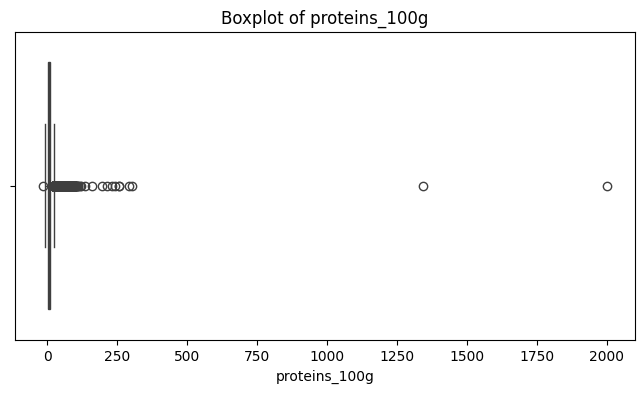

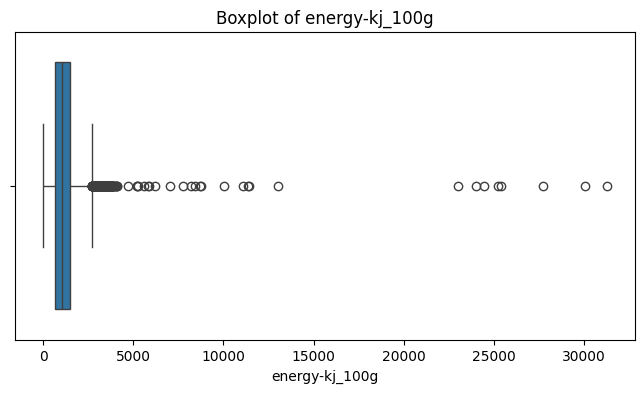

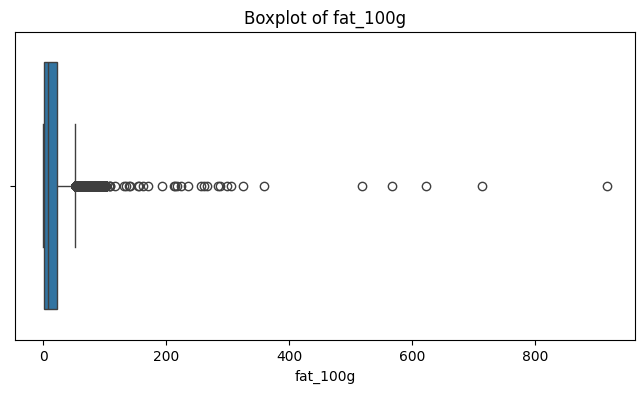

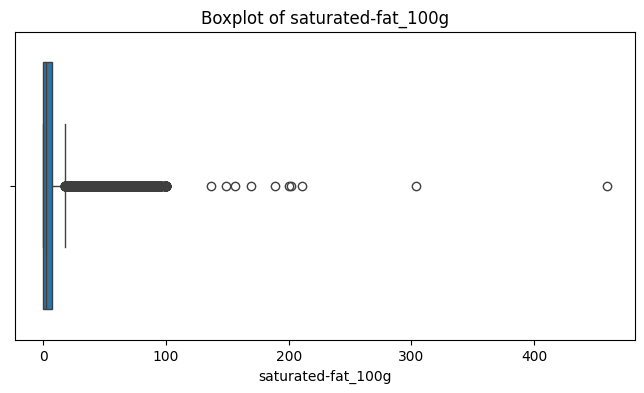

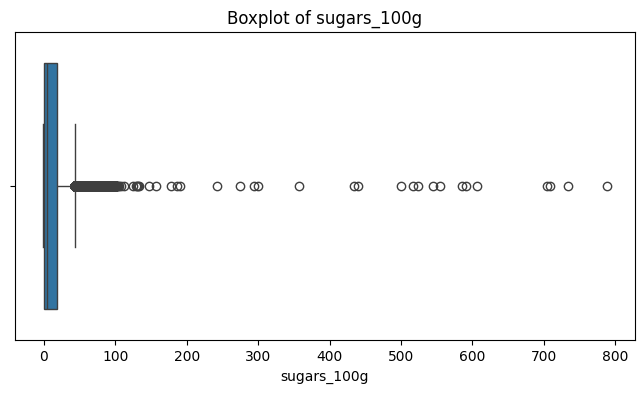

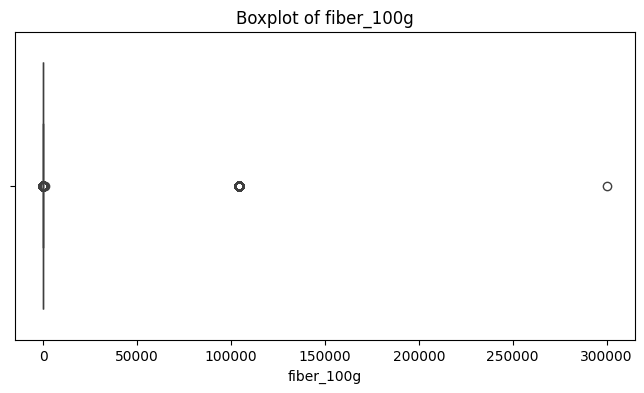

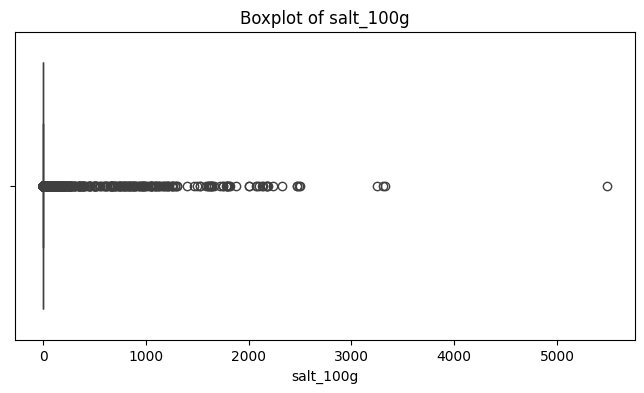

In [24]:
for column in nutrition_data.select_dtypes(include=['float64']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=nutrition_data[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

In [4]:
def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range

        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter rows within the range
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

# Select numeric columns for outlier removal
numeric_columns = nutrition_data.select_dtypes(include='float').columns

# Remove outliers
nutrition_data_no_outliers = remove_outliers_iqr(nutrition_data, numeric_columns)

print(f"Shape before removing outliers: {nutrition_data.shape}")
print(f"Shape after removing outliers: {nutrition_data_no_outliers.shape}")

Shape before removing outliers: (563226, 8)
Shape after removing outliers: (387531, 8)


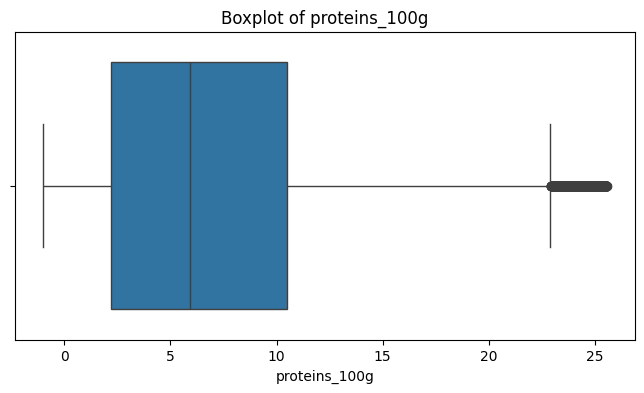

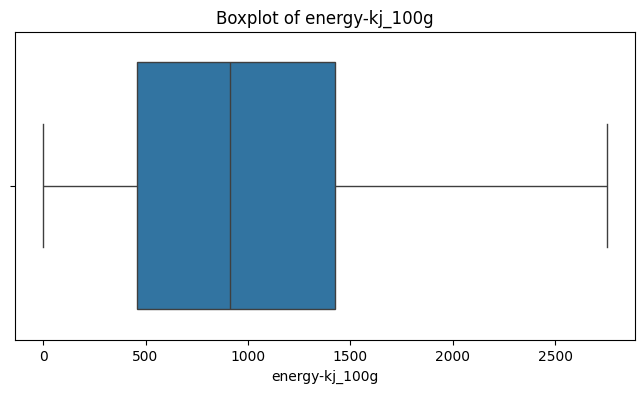

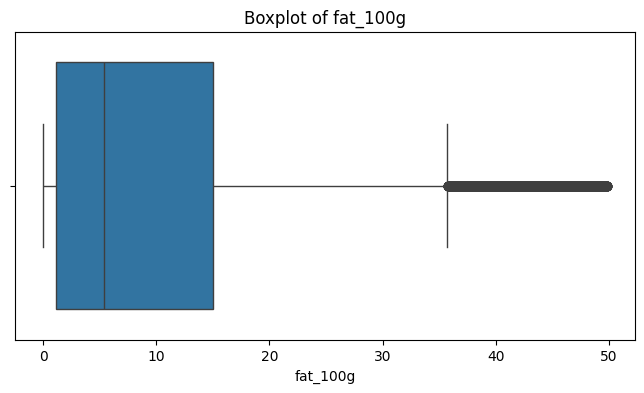

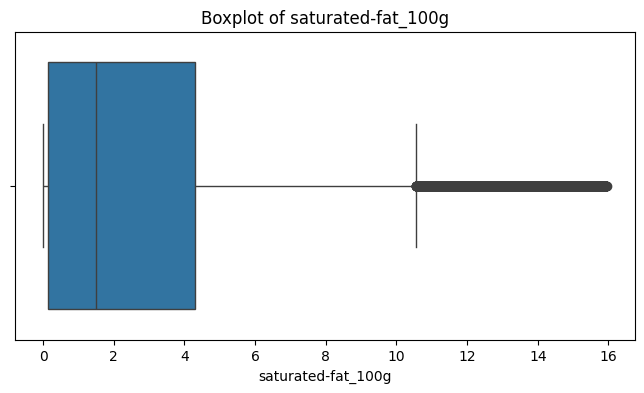

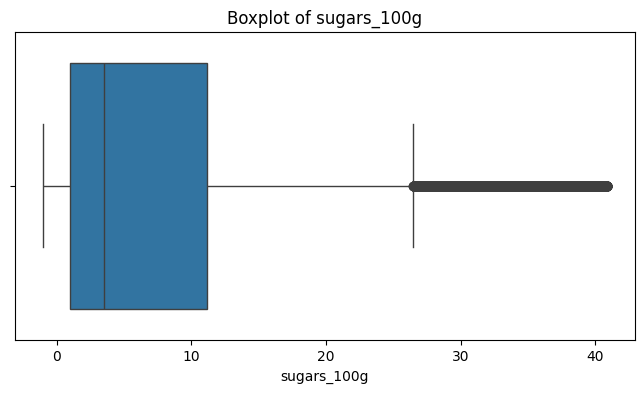

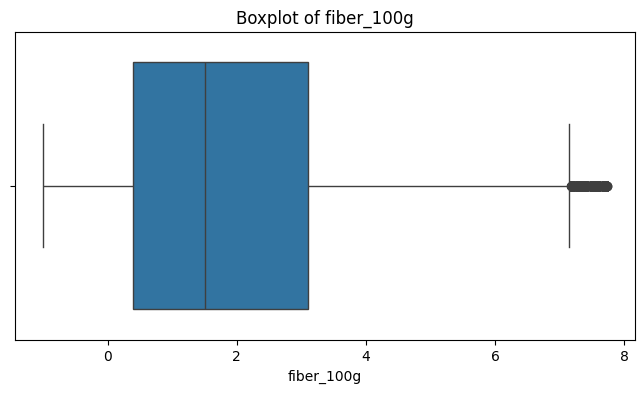

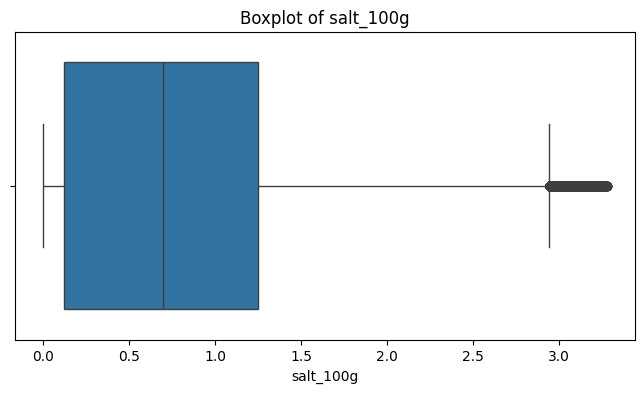

In [26]:
for column in nutrition_data_no_outliers.select_dtypes(include=['float64']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=nutrition_data_no_outliers[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

In [5]:
nutrition_data_no_outliers = nutrition_data_no_outliers.reset_index().drop(columns = 'index')
nutrition_data_no_outliers

,proteins_100g,nutriscore_grade,energy-kj_100g,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g
0,10.0,a,542.262831,0.2,0.1,3.9,0.626513,0.09
1,0.2,d,193.400710,0.0,0.0,15.5,0.426750,0.00
2,0.9,b,683.809497,0.3,0.1,3.9,2.098569,0.42
3,4.6,d,1055.578361,22.0,15.5,21.9,4.400000,0.10
4,0.6,a,401.112130,0.0,0.0,27.0,3.600000,0.00
...,...,...,...,...,...,...,...,...
387526,7.1,e,1540.909213,20.0,12.0,20.0,2.399488,0.58
387527,10.0,d,1055.578361,9.8,3.5,5.5,1.906709,1.23
387528,2.9,c,542.262831,6.1,4.3,14.0,0.626513,0.08
387529,7.0,b,1425.870333,0.5,0.0,0.0,4.951478,0.00


# Scaling

In [28]:
scaler = MinMaxScaler()

# Fit and transform the DataFrame
df = nutrition_data_no_outliers
nutrition_normalized = pd.DataFrame(scaler.fit_transform(df.select_dtypes(include='float')),columns = df.select_dtypes(include='float').columns)
nutrition_normalized = pd.concat([nutrition_normalized, df.drop(columns=df.select_dtypes(include='float').columns)], axis=1)

In [29]:
nutrition_normalized.head()

,proteins_100g,energy-kj_100g,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g,nutriscore_grade
0,0.414313,0.197186,0.004016,0.006270,0.117085,0.186313,0.027458,a
1,0.045198,0.070328,0.000000,0.000000,0.394265,0.163431,0.000000,d
2,0.071563,0.248658,0.006024,0.006270,0.117085,0.354933,0.128136,b
3,0.210923,0.383847,0.441767,0.971787,0.547192,0.618557,0.030508,d
4,0.060264,0.145859,0.000000,0.000000,0.669056,0.526919,0.000000,a


In [ ]:
nutrition_data.columns

In [ ]:
nutrition_data_fe = nutrition_data.copy()

In [ ]:
nutrition_data_fe['']

# Encoding

In [30]:
label_encoder = LabelEncoder()

In [31]:
# Assume 'nutrition_data' is your DataFrame and 'nutrigrade_score' is the label column
X = nutrition_normalized.drop(columns=['nutriscore_grade'])  # Features (exclude label)
y = nutrition_normalized['nutriscore_grade']  # Label (target)

# If 'nutrigrade_score' is categorical, encode it
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# a -> 0, b -> 1, c -> 2, d -> 3, e -> 4

# Train Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Models

## Tensorflow NN

In [38]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
# Output layer (5 classes)
model.add(Dense(5, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,141 (168.52 KB)

 Trainable params: 43,141 (168.52 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(X_train, y_train, epochs=100 , batch_size=64, validation_split=0.2)

Epoch 1/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 3s 682us/step - accuracy: 0.7002 - loss: 0.7381 - val_accuracy: 0.7695 - val_loss: 0.5736
Epoch 2/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 3s 674us/step - accuracy: 0.7687 - loss: 0.5719 - val_accuracy: 0.7774 - val_loss: 0.5420
Epoch 3/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 3s 702us/step - accuracy: 0.7805 - loss: 0.5432 - val_accuracy: 0.7872 - val_loss: 0.5238
Epoch 4/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 3s 766us/step - accuracy: 0.7886 - loss: 0.5249 - val_accuracy: 0.7995 - val_loss: 0.5022
Epoch 5/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 3s 704us/step - accuracy: 0.7943 - loss: 0.5127 - val_accuracy: 0.7965 - val_loss: 0.5043
Epoch 6/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 3s 725us/step - accuracy: 0.7983 - loss: 0.5020 - val_accuracy: 0.8014 - val_loss: 0.4948
Epoch 7/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 3s 697us/step - accuracy: 0.8017 - loss: 0.4941 - val_accuracy: 0.8036 - val_loss: 0.4895
Epoch 8/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 3s 724us/step - accuracy: 

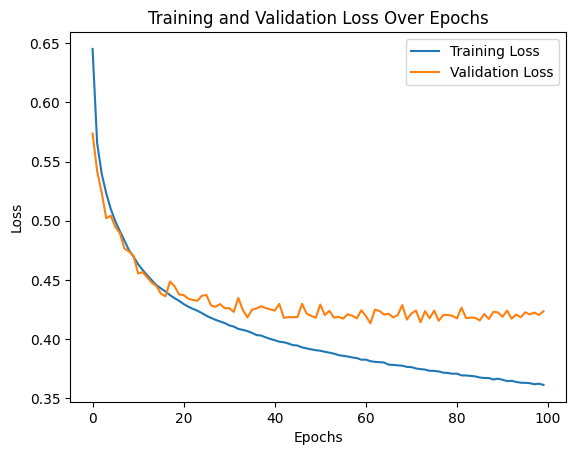

In [41]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

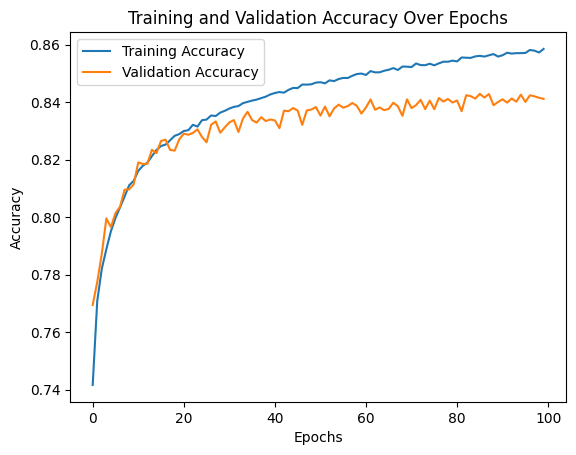

In [42]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [43]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accuracy: 0.8406 - loss: 0.4225
Test Loss: 0.426707923412323, Test Accuracy: 0.8403777480125427


## Random Forest

In [ ]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

## XGBoost

In [50]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the model
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8866439593332301
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      6777
           1       0.83      0.84      0.83      7231
           2       0.87      0.88      0.88      9711
           3       0.92      0.92      0.92      9915
           4       0.91      0.89      0.90      5120

    accuracy                           0.89     38754
   macro avg       0.89      0.89      0.89     38754
weighted avg       0.89      0.89      0.89     38754



## Ensemble RF XG

In [ ]:
from sklearn.ensemble import VotingClassifier

rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')
ensemble_model.fit(X_train, y_train)

In [ ]:
y_pred = ensemble_model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
from sklearn.metrics import roc_auc_score

# Predict probabilities
y_proba = ensemble_model.predict_proba(X_test)

# ROC-AUC (for multiclass)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

In [ ]:
# Binarize the output (one-vs-rest)
n_classes = len(set(y_test))  # Number of classes
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Predict probabilities for each class
y_proba = ensemble_model.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Configure plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Export Model

## Tensorflow

In [47]:
model.export('saved_model/capstone_tf_model')

INFO:tensorflow:Assets written to: saved_model/capstone_tf_model\assets


INFO:tensorflow:Assets written to: saved_model/capstone_tf_model\assets


Saved artifact at 'saved_model/capstone_tf_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1453148496592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1453148495440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1453148497552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1453148491600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1453148493712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1453148496208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1453148496016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1453148495056: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [49]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/capstone_tf_model')  # Use your saved model directory
# OR, if using a Keras model
# converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optimize the model for smaller size (optional)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('capstone_tf_model.tflite', 'wb') as f:
    f.write(tflite_model)

## XGB

In [54]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [55]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [56]:
import onnxmltools
from onnxmltools.convert import convert_xgboost
from onnxmltools.convert.common.data_types import FloatTensorType

In [57]:
booster = xgb_model.get_booster()
original_feature_names = booster.feature_names
if original_feature_names is not None:
    onnx_converter_conform_feature_names = [f"f{num}" for num in range(len(original_feature_names))]
    booster.feature_names = onnx_converter_conform_feature_names

In [58]:
original_feature_names

['proteins_100g',
 'energy-kj_100g',
 'fat_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'fiber_100g',
 'salt_100g']

In [59]:
booster.feature_names

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']

In [60]:
# Load the trained XGBoost model
xgb_model = joblib.load('xgb_model.pkl')

In [64]:

# Define the input types (adjust 'n_features' to the actual number of features in your dataset)
# For example, if you have 5 features, replace `n_features` with 5
initial_types = [('input', FloatTensorType([None, 7]))] 

# Convert the XGBoost model to ONNX
onnx_model = convert_xgboost(booster,'xgboost_classifier', initial_types=initial_types)

# Save the ONNX model to a file
onnxmltools.utils.save_model(onnx_model, 'xgb_model.onnx')

# Path

In [68]:
import os

# Replace 'folder_or_file_name' with your folder or file name
folder_or_file_name = 'saved-model'

# Get the absolute path
absolute_path = os.path.abspath(folder_or_file_name)
print(f"Absolute Path: {absolute_path}")


Absolute Path: C:\Users\ARGA\CapstoneProject\saved-model
